##Installations

In [ ]:
!pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.3 MB/s eta 0:00:00


##Imports

In [ ]:
# The standard fare, plus a few extra packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os.path
%matplotlib inline

# Newer packages:
# You may need to install them via pip
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from photutils.utils import calc_total_error
import astropy.stats as stat

from photutils.aperture import aperture_photometry, ApertureStats, CircularAperture, CircularAnnulus
from photutils.detection import DAOStarFinder

from IPython.display import Image

from scipy.spatial.distance import cdist
from scipy.optimize import minimize

##Function Definitons

In [ ]:
def bg_error_estimate(fitsfile):
    """
    Calculates the total error on the image based on:
    Background values, effective gain, and image data.
    inputs: file path (fitsfile)
    output: the error image (not just a path but the actual image/values)
    """
    fitsdata = fits.getdata(fitsfile) # gets the data from the file
    hdr = fits.getheader(fitsfile) # gets the header from file

    # This just performs sigma clipping, which is to say it checks each
    # one and either rejects or accepts it given the sigma val input into the function.
    # here the sigma val is 3 and it uses the data we just loaded.
    filtered_data = sigma_clip(fitsdata, sigma=3.,copy=False)

    # 1: Replaces values above 3*sigma limit with nan.
    bkg_values_nan = filtered_data.filled(fill_value=np.nan)
    #2: Takes square root of background values.
    bkg_error = np.sqrt(bkg_values_nan)
    #3: Takes median of background error, ignoring "nan" values/outliers and replacing the nan values with that.
    # makes all of those just the median background
    bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)

    print("Writing the background-only error image: ", fitsfile.split('.')[0]+"_bgerror.fit")
    fits.writeto(fitsfile.split('.')[0]+"_bgerror.fit", bkg_error, hdr, overwrite=True) #writes file

    effective_gain = 1.4 # electrons per ADU

    error_image = calc_total_error(fitsdata, bkg_error, effective_gain)
    #calculates total error based on given variables.

    print("Writing the total error image: ", fitsfile.split('.')[0]+"_error.fit")
    fits.writeto(fitsfile.split('.')[0]+"_error.fit", error_image, hdr, overwrite=True)
    #writes to file

    return error_image

In [ ]:
# Star extraction function
def starExtractor(fitsfile, nsigma_value, fwhm_value):
    """
    This actually finds the stars in our image, using donwloaded functions.
    input: fitsfile (path), the sigma vlaue (float), fwhm (float)
    output: the x and y positon of all stars in our image (variables),
    also writes the positions to a .reg file
    """

    # First, check if the region file exists yet, so it doesn't get overwritten
    regionfile = fitsfile.split(".")[0] + ".reg"

    if os.path.exists(regionfile) == True:
        print(regionfile, "already exists in this directory. Rename or remove the .reg file and run again.")
        return

    image = fits.getdata(fitsfile)

    # *** Measure the median absolute standard deviation of the image: ***
    bkg_sigma = mad_std(image)

    # *** Define the parameters for DAOStarFinder ***
    daofind = DAOStarFinder(threshold = nsigma_value * bkg_sigma, fwhm = fwhm_value)    # note we did not change these to go against the default values

    # Apply DAOStarFinder to the image
    sources = daofind(image)
    nstars = len(sources)
    print("Number of stars found in ",fitsfile,":", nstars)

    # Define arrays of x-position and y-position
    xpos = np.array(sources['xcentroid'])
    ypos = np.array(sources['ycentroid'])

    # Write the positions to a .reg file based on the input file name
    if os.path.exists(regionfile) == False:
        f = open(regionfile, 'w')
        for i in range(0,len(xpos)):
            f.write('circle '+str(xpos[i])+' '+str(ypos[i])+' '+str(fwhm_value)+'\n')
        f.close()
        print("Wrote ", regionfile)
        return xpos, ypos # Return the x and y positions of each star as variables


In [ ]:
# Photometry function
def measurePhotometry(fitsfile, star_xpos, star_ypos, aperture_radius, sky_inner, sky_outer, error_array):
    """
    This function calculates background counts and
    the error on the background counts (of the star)
    inputs: fitsfile(path), x and y pos of the star(arrays),
    ap rad (float), inner rad of the sky ann (float), outer sky ann(float),
    error array(array)
    output: the error propogation of the backround on the star (table)
    """
    image = fits.getdata(fitsfile)

    star_pos = np.vstack([star_xpos, star_ypos]).T # makes a stack of all the stars positions

    starapertures = CircularAperture(star_pos,r = aperture_radius) # makes the aperatures around each star
    skyannuli = CircularAnnulus(star_pos, r_in = sky_inner, r_out = sky_outer) # makes the annuli in the same way (for the background)
    phot_apers = [starapertures, skyannuli] # Puts values for star in list.

    phot_table = aperture_photometry(image, phot_apers, error=error_array)
    # This function now uses an error array, which was calculated earlier
    #it is now part of the function.

    # Calculate mean background in annulus and subtract from aperture flux
    bkg_mean = phot_table['aperture_sum_1'] / skyannuli.area
    bkg_starap_sum = bkg_mean * starapertures.area
    final_sum = phot_table['aperture_sum_0']-bkg_starap_sum
    phot_table['bg_subtracted_star_counts'] = final_sum

    bkg_mean_err = phot_table['aperture_sum_err_1'] / skyannuli.area
    bkg_sum_err = bkg_mean_err * starapertures.area
    #The first function calculates the total aperture error,
    #divided by the area of the annulus.
    #The second function takes the mean error and
    #multiplies it by the area of the star.
    #Therefore, this is the estimated error on the star.

    phot_table['bg_sub_star_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2))
    #error propagation of background counts on star.

    return phot_table

In [ ]:
def error_magnitude(df, name, variable):
    """
    gets the inst. mag error and adds to dataframe.
    Really small helper function dats the df, name of columns and first letter of the filter.
    outputs the error.
    """
    total_error = 2.5 * 0.434* (df[f"{variable}flux_1sec_err"] / df[f"{variable}flux_1sec"])
    df[name] = total_error
    return total_error

In [ ]:
def zpcalc(magzp, magzp_err, filtername, df):
    '''
    This calculates the calibrated magnitues and its errors.
    Inputs: zp (float), err zp (float), first letter of the filter (string), dataframe
    outputs: nothing, but makes the columns
    '''
    mag = df[f"{filtername}inst"] + magzp
    err = (df[f"{filtername}inst_err"]**2 + magzp_err**2)**0.5
    df[f"{filtername}mag"] = mag
    df[f"{filtername}mag_err"] = err
    return None

In [ ]:
# custom weighted least squares fitting function, semi close to the chi-square
# hurt my heart to do chi by eye

def chisquareish(shifts, obs_c, obs_c_err, obs_m, obs_m_err, iso_c, iso_m, iso_c_err = None, iso_m_err = None):
  '''
  This calculates the chi square statistics for the isochrone fitting.

  Parameters:
  shifts (list), x and y shifts
  obs_c (array), observed colors
  obs_c_err (array), observed color errors
  obs_m (array), observed magnitudes
  obs_m_err (array), observed magnitude errors
  iso_c (array), isochrone colors
  iso_m (array), isochrone magnitudes
  iso_c_err (array), isochrone color errors
  iso_m_err (array), isochrone magnitude errors

  Returns:
  chi_sq (float), the chi square value
  '''
  iso_c_err = np.zeros(len(iso_c))
  iso_m_err = np.zeros(len(iso_m))

  # unpacks the coordinates
  shift_x, shift_y = shifts

  #shifts the isochrome according to those
  shifted_iso_c = shift_x + iso_c
  shifted_iso_m = shift_y + iso_m

  # stick them inot arrays of the same dimension
  # if not i kept fucking up the math
  # make them column mtx (no need to transpose later)
  # nx2
  observed_points = np.column_stack((obs_c, obs_m))
  isochrone_points = np.column_stack((shifted_iso_c, shifted_iso_m))

  # gets the euclidian distance along all of the mtx values
  # lets me use the shortest one as this is not a normal function so not always the same
  dists = cdist(observed_points, isochrone_points, metric='euclidean')
  min_dists = np.min(dists, axis=1)

  # this gets the closest point on the isochrome
  closest_indices = np.argmin(dists, axis=1)
  matched_iso_c_err = iso_c_err[closest_indices]
  matched_iso_m_err = iso_m_err[closest_indices]

  # variance calculation (zero error on the isochromes from what i can see)
  sigma2_color = obs_c_err**2 + matched_iso_c_err**2
  sigma2_mag   = obs_m_err**2 + matched_iso_m_err**2
  total_variance = sigma2_color + sigma2_mag

  # the chi squared calculation
  # there is no error on the isochrome so imagine an invisible 1 under it
  chi_sq_terms = (min_dists**2) / total_variance
  chi_sq = np.sum(chi_sq_terms)

  return chi_sq

##DataFrame Creation

Standard star (All of this is voided but will keep it for archival purposes)

In [ ]:
# Measure the background of the image
# the paths are written as if this is being run in the same folder as them
# made for the std star specifically and how it is a binary it seems
# this is not voided but kept for reference
std_V_bgerror = bg_error_estimate("aligned_aligned_master_stack_visual.fit")
std_V_xpos, std_V_ypos = starExtractor("aligned_aligned_master_stack_visual.fit", nsigma_value=14, fwhm_value=8)
std_V_phottable = measurePhotometry("aligned_aligned_master_stack_visual.fit", star_xpos=std_V_xpos, star_ypos=std_V_ypos, \
                                    aperture_radius=6.5, sky_inner= 14, sky_outer=24, error_array=std_V_bgerror)

/tmp/ipython-input-2697876718.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  aligned_aligned_master_stack_visual_bgerror.fit
Writing the total error image:  aligned_aligned_master_stack_visual_error.fit
Number of stars found in  aligned_aligned_master_stack_visual.fit : 267
Wrote  aligned_aligned_master_stack_visual.reg


In [ ]:
std_R_bgerror = bg_error_estimate("aligned_aligned_master_stack_red.fit")
std_R_phottable = measurePhotometry("aligned_aligned_master_stack_red.fit", star_xpos=std_V_xpos, star_ypos=std_V_ypos, \
                                    aperture_radius= 6.5, sky_inner=14, sky_outer=24, error_array=std_R_bgerror)

/tmp/ipython-input-2697876718.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  aligned_aligned_master_stack_red_bgerror.fit
Writing the total error image:  aligned_aligned_master_stack_red_error.fit


In [ ]:
std_B_bgerror = bg_error_estimate("aligned_aligned_master_stack_blue.fit")
std_B_phottable = measurePhotometry("aligned_aligned_master_stack_blue.fit", star_xpos=std_V_xpos, star_ypos=std_V_ypos, \
                                    aperture_radius=6.6, sky_inner=14.5, sky_outer=24.5, error_array=std_B_bgerror)

/tmp/ipython-input-2697876718.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  aligned_aligned_master_stack_blue_bgerror.fit
Writing the total error image:  aligned_aligned_master_stack_blue_error.fit


In [ ]:
columns = ['id','xcenter', 'ycenter','Vflux','Vfluxerr','Rflux','Rfluxerr', 'Bflux', 'Bfluxerr']
std_fluxtable = pd.DataFrame(
    {'id'      : std_V_phottable['id'],
     'xcenter' : std_V_phottable['xcenter'],
     'ycenter' : std_V_phottable['ycenter'],
     'Vflux'   : std_V_phottable['bg_subtracted_star_counts'],
     'Vfluxerr': std_V_phottable['bg_sub_star_cts_err'],
     'Rflux'   : std_R_phottable['bg_subtracted_star_counts'],
     'Rfluxerr': std_R_phottable['bg_sub_star_cts_err'],
     'Bflux'   : std_B_phottable['bg_subtracted_star_counts'],
     'Bfluxerr': std_B_phottable['bg_sub_star_cts_err']}, columns=columns)

M52 Cluster work

In [ ]:
# Measure the background of the image
# the paths are written as if this is being run in the same folder as them
# we tried this for multiple values in place and re-ran the code
M52_V_bgerror = bg_error_estimate("aligned_aligned_trimmed_master_stack_visual.fit")
M52_V_xpos, M52_V_ypos = starExtractor("aligned_aligned_trimmed_master_stack_visual.fit", nsigma_value=13, fwhm_value=10)
M52_V_phottable = measurePhotometry("aligned_aligned_trimmed_master_stack_visual.fit", star_xpos=M52_V_xpos, star_ypos=M52_V_ypos, \
                                    aperture_radius=7, sky_inner=12, sky_outer=20, error_array=M52_V_bgerror)

/tmp/ipython-input-2697876718.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  aligned_aligned_trimmed_master_stack_visual_bgerror.fit
Writing the total error image:  aligned_aligned_trimmed_master_stack_visual_error.fit
Number of stars found in  aligned_aligned_trimmed_master_stack_visual.fit : 1674
Wrote  aligned_aligned_trimmed_master_stack_visual.reg


In [ ]:
M52_R_bgerror = bg_error_estimate("aligned_aligned_trimmed_master_stack_red.fit")
M52_R_phottable = measurePhotometry("aligned_aligned_trimmed_master_stack_red.fit", star_xpos=M52_V_xpos, star_ypos=M52_V_ypos, \
                                    aperture_radius=7.5, sky_inner=13, sky_outer=21, error_array=M52_R_bgerror)

/tmp/ipython-input-2697876718.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  aligned_aligned_trimmed_master_stack_red_bgerror.fit
Writing the total error image:  aligned_aligned_trimmed_master_stack_red_error.fit


In [ ]:
M52_B_bgerror = bg_error_estimate("aligned_aligned_trimmed_master_stack_blue.fit")
M52_B_phottable = measurePhotometry("aligned_aligned_trimmed_master_stack_blue.fit", star_xpos=M52_V_xpos, star_ypos=M52_V_ypos, \
                                    aperture_radius=8, sky_inner=14, sky_outer=22, error_array=M52_B_bgerror)

/tmp/ipython-input-2697876718.py:21: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  aligned_aligned_trimmed_master_stack_blue_bgerror.fit
Writing the total error image:  aligned_aligned_trimmed_master_stack_blue_error.fit


In [ ]:
M52_fluxtable = pd.DataFrame(
    {'id'      : M52_V_phottable['id'],
     'xcenter' : M52_V_phottable['xcenter'],
     'ycenter' : M52_V_phottable['ycenter'],
     'Vflux'   : M52_V_phottable['bg_subtracted_star_counts'],
     'Vfluxerr': M52_V_phottable['bg_sub_star_cts_err'],
     'Rflux'   : M52_R_phottable['bg_subtracted_star_counts'],
     'Rfluxerr': M52_R_phottable['bg_sub_star_cts_err'],
     'Bflux'   : M52_B_phottable['bg_subtracted_star_counts'],
     'Bfluxerr': M52_B_phottable['bg_sub_star_cts_err']}, columns=columns)

## Normalization

Standard Normalization and error propogation (Again, archival)

In [ ]:
# gets the exposure times
header_std_red = fits.getheader("aligned_aligned_master_stack_red.fit")
exptime_red_std = header_std_red["EXPTIME"]

header_std_vis = fits.getheader("aligned_aligned_master_stack_visual.fit")
exptime_vis_std = header_std_vis["EXPTIME"]

header_std_blue = fits.getheader("aligned_aligned_master_stack_blue.fit")
exptime_blue_std = header_std_blue["EXPTIME"]

In [ ]:
# calculates the normalized flux
std_fluxtable["Vflux_1sec"] = std_fluxtable["Vflux"] / exptime_vis_std
std_fluxtable["Rflux_1sec"] = std_fluxtable["Rflux"] / exptime_red_std
std_fluxtable["Bflux_1sec"] = std_fluxtable["Bflux"] / exptime_red_std
std_fluxtable["Bflux_1sec_err"] = std_fluxtable["Bfluxerr"] / exptime_vis_std
std_fluxtable["Vflux_1sec_err"] = std_fluxtable["Vfluxerr"] / exptime_vis_std
std_fluxtable["Rflux_1sec_err"] = std_fluxtable["Rfluxerr"] / exptime_red_std

In [ ]:
# instrumental magnitude calc
std_fluxtable["Vinst"] = -2.5 * (np.log10(std_fluxtable["Vflux_1sec"]))
std_fluxtable["Rinst"] = -2.5 * (np.log10(std_fluxtable["Rflux_1sec"]))
std_fluxtable["Binst"] = -2.5 * (np.log10(std_fluxtable["Bflux_1sec"]))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# error for the instrumental magnitudes
error_magnitude(std_fluxtable, "Vinst_err", "V")
error_magnitude(std_fluxtable, "Rinst_err", "R")
error_magnitude(std_fluxtable, "Binst_err", "B")

,0
0,-0.158347
1,0.084006
2,0.017829
3,0.103045
4,0.042701
...,...
262,0.018784
263,0.025998
264,0.046840
265,0.031774


M52 normalization and error propogation. Also, includes our standard star.

In [ ]:
# gets the exptime
header_52_red = fits.getheader("aligned_aligned_trimmed_master_stack_red.fit")
exptime_red_52 = header_52_red["EXPTIME"]

header_52_vis = fits.getheader("aligned_aligned_trimmed_master_stack_visual.fit")
exptime_vis_52 = header_52_vis["EXPTIME"]

header_52_blue = fits.getheader("aligned_aligned_trimmed_master_stack_blue.fit")
exptime_blue_52 = header_52_blue["EXPTIME"]

In [ ]:
# normlaized flux calc
M52_fluxtable["Vflux_1sec"] = M52_fluxtable["Vflux"] / exptime_vis_52
M52_fluxtable["Rflux_1sec"] = M52_fluxtable["Rflux"] / exptime_red_52
M52_fluxtable["Bflux_1sec"] = M52_fluxtable["Bflux"] / exptime_red_52
M52_fluxtable["Bflux_1sec_err"] = M52_fluxtable["Bfluxerr"] / exptime_vis_52
M52_fluxtable["Vflux_1sec_err"] = M52_fluxtable["Vfluxerr"] / exptime_vis_52
M52_fluxtable["Rflux_1sec_err"] = M52_fluxtable["Rfluxerr"] / exptime_red_52

In [ ]:
# instrumental magnitude calc
M52_fluxtable["Vinst"] = -2.5 * (np.log10(M52_fluxtable["Vflux_1sec"]))
M52_fluxtable["Rinst"] = -2.5 * (np.log10(M52_fluxtable["Rflux_1sec"]))
M52_fluxtable["Binst"] = -2.5 * (np.log10(M52_fluxtable["Bflux_1sec"]))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# error calc for instrumental mag
error_magnitude(M52_fluxtable, "Vinst_err", "V")
error_magnitude(M52_fluxtable, "Rinst_err", "R")
error_magnitude(M52_fluxtable, "Binst_err", "B")

,0
0,0.071432
1,0.010595
2,0.053535
3,0.067038
4,0.078718
...,...
1669,0.205008
1670,0.005508
1671,0.032793
1672,0.059864


## Generalize the Values

Zero point calculation, was updated for our new standard

https://simbad.cds.unistra.fr/simbad/sim-id?Ident=%4015032668&Name=UCAC4%20759-072456&submit=submit

In [ ]:
# finds the std star
mask = (M52_fluxtable["xcenter"] > 1035) & (M52_fluxtable["xcenter"] < 1075) & (M52_fluxtable["ycenter"] > 2700) & (M52_fluxtable["ycenter"] < 2740)
print(M52_fluxtable[mask])

        id      xcenter      ycenter         Vflux    Vfluxerr         Rflux  \
1415  1416  1052.949255  2720.369087  23101.103868  147.851012  24532.556104   

        Rfluxerr         Bflux    Bfluxerr  Vflux_1sec  ...  Bflux_1sec  \
1415  155.975504  20924.615622  147.378472  924.044155  ...  836.984625   

      Bflux_1sec_err  Vflux_1sec_err  Rflux_1sec_err     Vinst     Rinst  \
1415        5.895139         5.91404         6.23902 -7.414232 -7.479507   

         Binst  Vinst_err  Rinst_err  Binst_err  
1415 -7.306794   0.006944   0.006898   0.007642  

[1 rows x 21 columns]


In [ ]:
# merely to view
M52_fluxtable.iloc[1415]

,1415
id,1416.000000
xcenter,1052.949255
ycenter,2720.369087
Vflux,23101.103868
Vfluxerr,147.851012
Rflux,24532.556104
Rfluxerr,155.975504
Bflux,20924.615622
Bfluxerr,147.378472
Vflux_1sec,924.044155


In [ ]:
# zero pointing
magzp_V = 12.202 - (-7.414232)
magzp_V_error = (0.01**2 + 0.006944**2)**(1/2)

magzp_R =  11.992 - (-7.479507)
magzp_R_error = (0.05**2 + 0.006723**2)**(1/2)

magzp_B =  12.912 - (-7.306794)
magzp_B_error = (0.01**2 + 0.008088**2)**(1/2)

In [ ]:
# calculates the general magnitudes
zpcalc(magzp_V, magzp_V_error, "V", M52_fluxtable)
zpcalc(magzp_R, magzp_R_error, "R", M52_fluxtable)
zpcalc(magzp_B, magzp_B_error, "B", M52_fluxtable)

In [ ]:
# here is the color portion
# Add V-R column and V-R error column
# Also B-V
M52_fluxtable["V-R"] = M52_fluxtable["Vmag"] - M52_fluxtable["Rmag"]
M52_fluxtable["V-R_err"] = (M52_fluxtable["Vmag_err"]**2 + M52_fluxtable["Rmag_err"]**2)**0.5

M52_fluxtable["B-V"] = M52_fluxtable["Bmag"] - M52_fluxtable["Vmag"]
M52_fluxtable["B-V_err"] = (M52_fluxtable["Bmag_err"]**2 + M52_fluxtable["Vmag_err"]**2)**0.5

In [ ]:
M52_fluxtable.head()

,id,xcenter,ycenter,Vflux,Vfluxerr,Rflux,Rfluxerr,Bflux,Bfluxerr,Vflux_1sec,...,Vmag,Vmag_err,Rmag,Rmag_err,Bmag,Bmag_err,V-R,V-R_err,B-V,B-V_err
0,1,2180.424355,303.539130,1436.866843,75.172243,1036.091446,79.858612,1212.451698,79.822548,57.474674,...,15.217541,0.058055,15.427862,0.097667,16.004483,0.072580,-0.210321,0.113619,0.786942,0.092942
1,2,2247.140187,306.862664,11608.118296,115.697114,3940.777659,105.016567,12520.165141,122.258431,464.324732,...,12.949177,0.016284,13.977402,0.058148,13.469619,0.016663,-1.028225,0.060385,0.520441,0.023299
2,3,2700.192890,309.073769,1776.374035,77.559864,729.842901,80.394792,1711.372881,84.440759,71.054961,...,14.987246,0.048913,15.808284,0.129728,15.630282,0.055058,-0.821038,0.138643,0.643036,0.073647
3,4,1497.668267,310.257631,1470.959575,79.004355,482.326344,81.232492,1329.886441,82.168796,58.838383,...,15.192080,0.059533,16.258005,0.189570,15.904108,0.068261,-1.065924,0.198698,0.712027,0.090574
4,5,2430.775867,310.563970,1622.990908,78.442655,1270.975027,84.692675,1098.318170,79.683888,64.919636,...,15.085292,0.053835,15.206014,0.088162,16.111824,0.079761,-0.120723,0.103299,1.026532,0.096229


In [ ]:
M52_fluxtable.to_csv('M52_photometry_results.csv', index=False)

## Graphing CM with 3sig Clipping

In [ ]:
# light clipping from our csv values, same as any catalog
mask = (M52_fluxtable["B-V_err"] != np.inf) & (M52_fluxtable["V-R_err"] != np.inf) & (M52_fluxtable["Vmag_err"] != np.inf) & (M52_fluxtable["B-V_err"] != np.nan) & (M52_fluxtable["V-R_err"] != np.nan) & (M52_fluxtable["Vmag_err"] != np.nan)
M52_fluxtable = M52_fluxtable[mask]

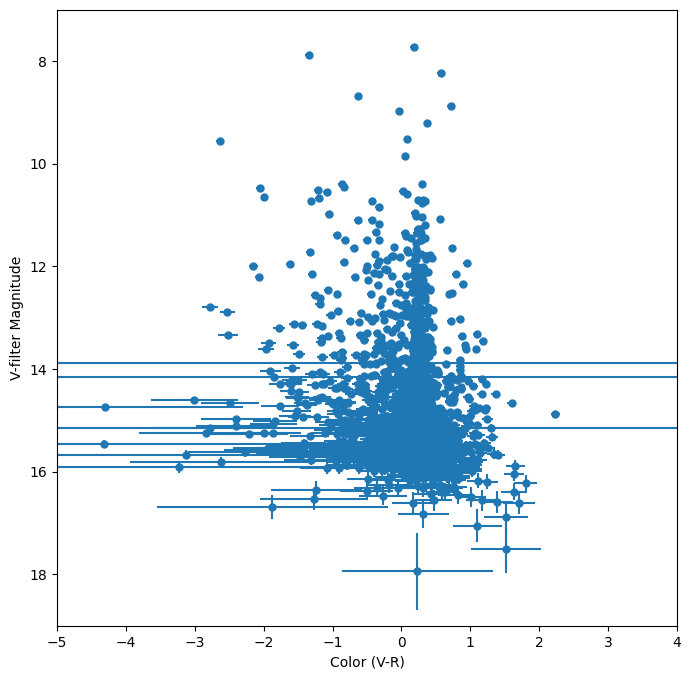

In [ ]:
# stat calc
limit_VR_err = np.nanmean(M52_fluxtable["V-R_err"]) + 3 * np.std(M52_fluxtable["V-R_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.std(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["V-R_err"] < limit_VR_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["V-R"], clean_data["Vmag"], xerr = clean_data["V-R_err"], yerr = clean_data["Vmag_err"], fmt = 'o', markersize = 5)
plt.xlabel("Color (V-R)")
plt.ylabel("V-filter Magnitude")
#plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,7])
plt.xlim([-5,4])
plt.show()

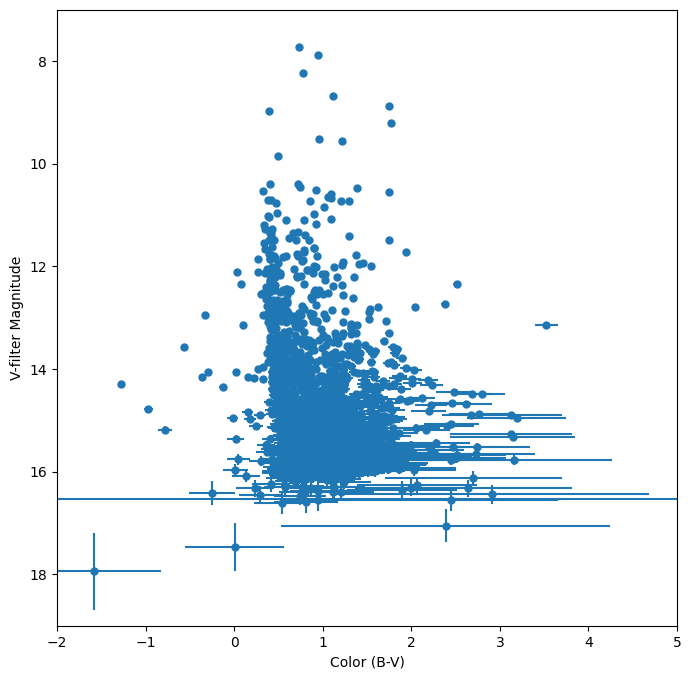

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["B-V_err"]) + 3 * np.nanstd(M52_fluxtable["B-V_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["B-V_err"] < limit_VR_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["B-V"], clean_data["Vmag"], xerr = clean_data["B-V_err"], yerr = clean_data["Vmag_err"], fmt = 'o', markersize = 5)
plt.xlabel("Color (B-V)")
plt.ylabel("V-filter Magnitude")
#plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,7])
plt.xlim([-2,5])
plt.show()

## Isochrone Fitting BV

Note the best fit model was updated, and the shifts have been fixed in the matrix image but as these were just an intermediary visual no need to fix them in here as it was just to make the initial guesses for the optimizer

In [ ]:
# Read in data files
e7 = pd.read_csv("isochrones_marigo08_1e7yr.txt", delim_whitespace=True, skiprows = 10)
e8 = pd.read_csv("isochrones_marigo08_1e8yr.txt", delim_whitespace=True, skiprows = 10)
e9= pd.read_csv("isochrones_marigo08_1e9yr.txt", delim_whitespace=True, skiprows = 10)
e10= pd.read_csv("isochrones_marigo08_1e10yr.txt", delim_whitespace=True, skiprows = 10)
e37= pd.read_csv("isochrones_marigo08_3e7yr.txt", delim_whitespace=True, skiprows = 10)
e38= pd.read_csv("isochrones_marigo08_3e8yr.txt", delim_whitespace=True, skiprows = 10)

/tmp/ipython-input-794562858.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  e7 = pd.read_csv("isochrones_marigo08_1e7yr.txt", delim_whitespace=True, skiprows = 10)
/tmp/ipython-input-794562858.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  e8 = pd.read_csv("isochrones_marigo08_1e8yr.txt", delim_whitespace=True, skiprows = 10)
/tmp/ipython-input-794562858.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  e9= pd.read_csv("isochrones_marigo08_1e9yr.txt", delim_whitespace=True, skiprows = 10)
/tmp/ipython-input-794562858.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  e10= pd.read_csv("iso

e7

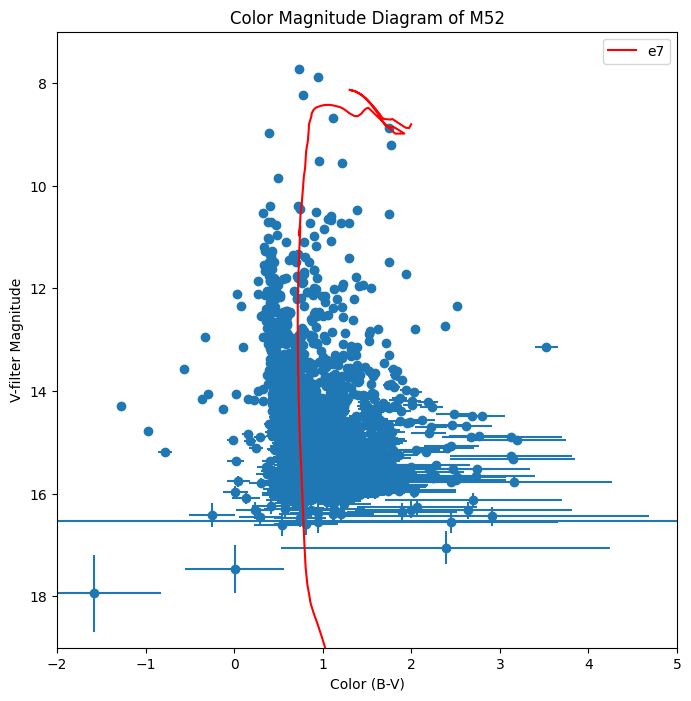

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["B-V_err"]) + 3 * np.nanstd(M52_fluxtable["B-V_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["B-V_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["B-V"], clean_data["Vmag"], xerr = clean_data["B-V_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e7["B"] - e7["V"] + 0.8348905891534959, e7["V"] + 16.250192519812153, c = "r", label = "e7", zorder = 2)
plt.xlabel("Color (B-V)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,7])
plt.xlim([-2,5])
plt.legend()
plt.show()

In [ ]:
# initial guess
initial_guess = [0, 16]
# just use the pre-built, wont be perfect but at least it is a little better than guessing
minimized_value = minimize(chisquareish,
                           initial_guess,
                           args=(M52_fluxtable["B-V"], M52_fluxtable["B-V_err"], M52_fluxtable["Vmag"], M52_fluxtable["Vmag_err"], e7["B"] - e7["V"], e7["V"]),
                           method='Nelder-Mead',
                           options={
                               'maxiter': 5000,
                               'maxfev': 5000,
                               'disp': True
                           })
# can use this to plot it
best_shift_x, best_shift_y = minimized_value.x
print(best_shift_x)
print(best_shift_y)

Optimization terminated successfully.
         Current function value: 88610.236969
         Iterations: 86
         Function evaluations: 166
0.8348905891534959
16.250192519812153


3e7

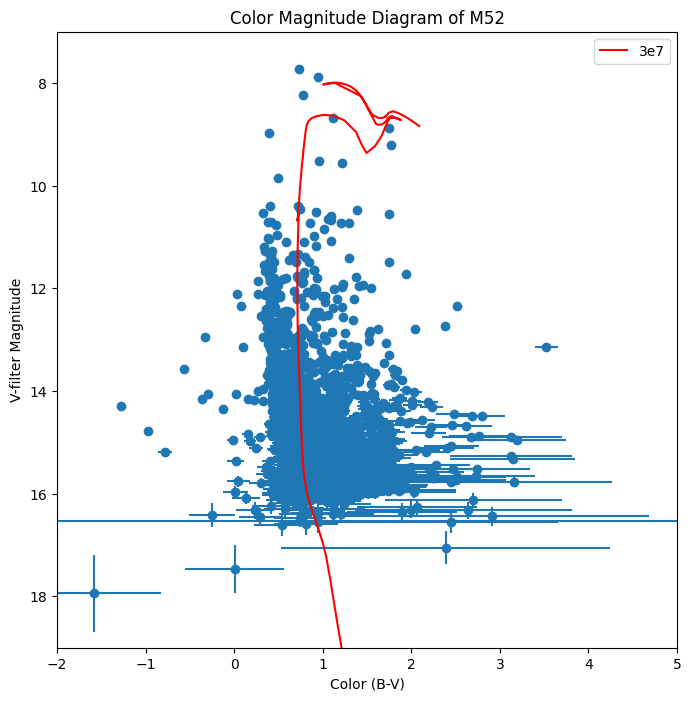

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["B-V_err"]) + 3 * np.nanstd(M52_fluxtable["B-V_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["B-V_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["B-V"], clean_data["Vmag"], xerr = clean_data["B-V_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e37["B"] - e37["V"] + 0.800279921742284, e37["V"] + 14.1753949248116, c = "r", label = "3e7", zorder = 2)
plt.xlabel("Color (B-V)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,7])
plt.xlim([-2,5])
plt.legend()
plt.show()

In [ ]:
# initial guess
initial_guess = [1, 14]
# just use the pre-built, wont be perfect but at least it is a little better than guessing
minimized_value = minimize(chisquareish,
                           initial_guess,
                           args=(M52_fluxtable["B-V"], M52_fluxtable["B-V_err"], M52_fluxtable["Vmag"], M52_fluxtable["Vmag_err"], e37["B"] - e37["V"], e37["V"]),
                           method='Nelder-Mead',
                           options={
                               'maxiter': 5000,
                               'maxfev': 5000,
                               'disp': True
                           })
# can use this to plot it
best_shift_x, best_shift_y = minimized_value.x
print(best_shift_x)
print(best_shift_y)

Optimization terminated successfully.
         Current function value: 81883.915571
         Iterations: 38
         Function evaluations: 74
0.800279921742284
14.1753949248116


e8

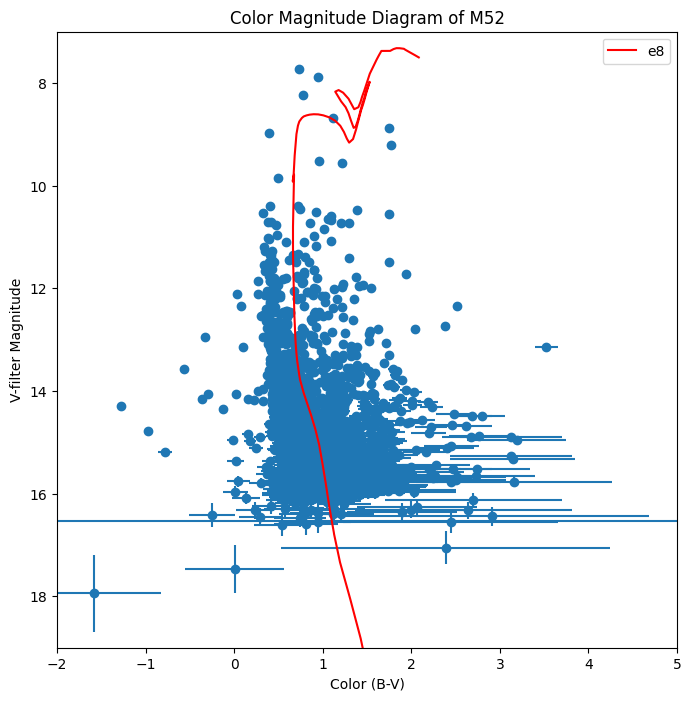

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["B-V_err"]) + 3 * np.nanstd(M52_fluxtable["B-V_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["B-V_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["B-V"], clean_data["Vmag"], xerr = clean_data["B-V_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e8["B"] - e8["V"] + 0.7171673757676543, e8["V"]+ 11.977361299346535, c = "r", label = "e8", zorder = 2)
plt.xlabel("Color (B-V)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,7])
plt.xlim([-2,5])
plt.legend()
plt.show()

In [ ]:
# initial guess
initial_guess = [1, 10.5]
# just use the pre-built, wont be perfect but at least it is a little better than guessing
minimized_value = minimize(chisquareish,
                           initial_guess,
                           args=(M52_fluxtable["B-V"], M52_fluxtable["B-V_err"], M52_fluxtable["Vmag"], M52_fluxtable["Vmag_err"], e8["B"] - e8["V"], e8["V"]),
                           method='Nelder-Mead',
                           options={
                               'maxiter': 5000,
                               'maxfev': 5000,
                               'disp': True
                           })
# can use this to plot it
best_shift_x, best_shift_y = minimized_value.x
print(best_shift_x)
print(best_shift_y)

Optimization terminated successfully.
         Current function value: 83706.862717
         Iterations: 44
         Function evaluations: 85
0.7171673757676543
11.977361299346535


The ones that fail the chi by eye test, and as such will not be considered fro the actual chi testing

These graphs were so off the math actually forces them down so the red giant branch is forced on top of the MS stars. A giveaway these are too old and developed, and the lightweight optimizer does not intrinsically note this is physically impossible so we manually do it.

3e8

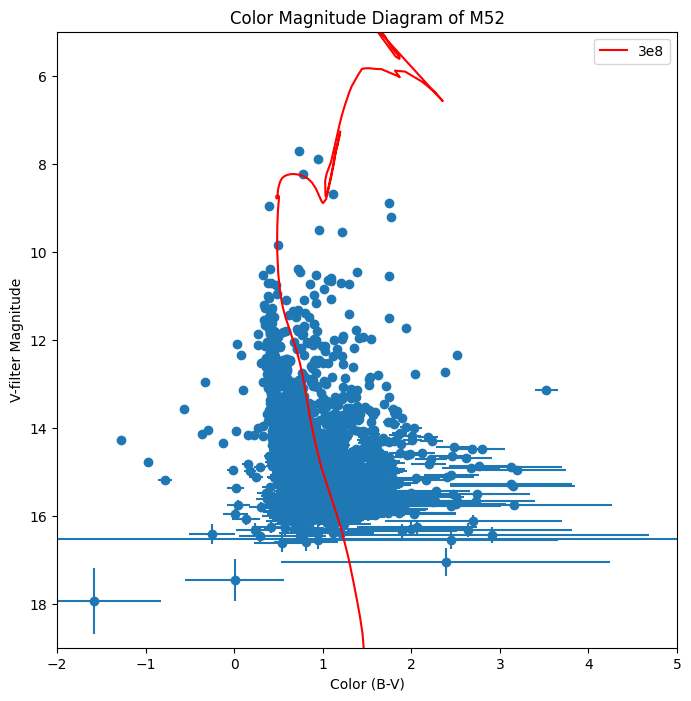

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["B-V_err"]) + 3 * np.nanstd(M52_fluxtable["B-V_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["B-V_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["B-V"], clean_data["Vmag"], xerr = clean_data["B-V_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e38["B"] - e38["V"] + 0.5, e38["V"] + 9.5, c = "r", label = "3e8", zorder = 2)
plt.xlabel("Color (B-V)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,5])
plt.xlim([-2,5])
plt.legend()
plt.show()

e9

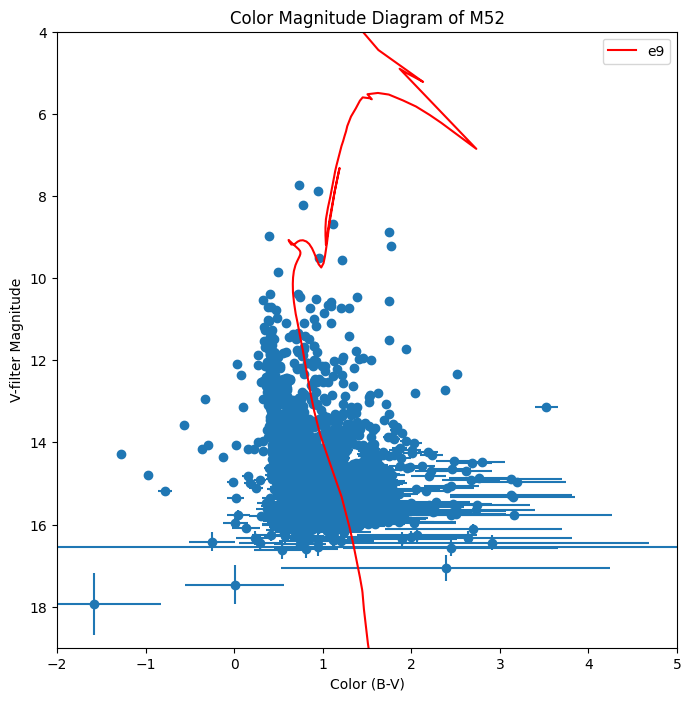

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["B-V_err"]) + 3 * np.nanstd(M52_fluxtable["B-V_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["B-V_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["B-V"], clean_data["Vmag"], xerr = clean_data["B-V_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e9["B"] - e9["V"] + 0.5, e9["V"]+8.5, c = "r", label = "e9", zorder = 2)
plt.xlabel("Color (B-V)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,4])
plt.xlim([-2,5])
plt.legend()
plt.show()

e10

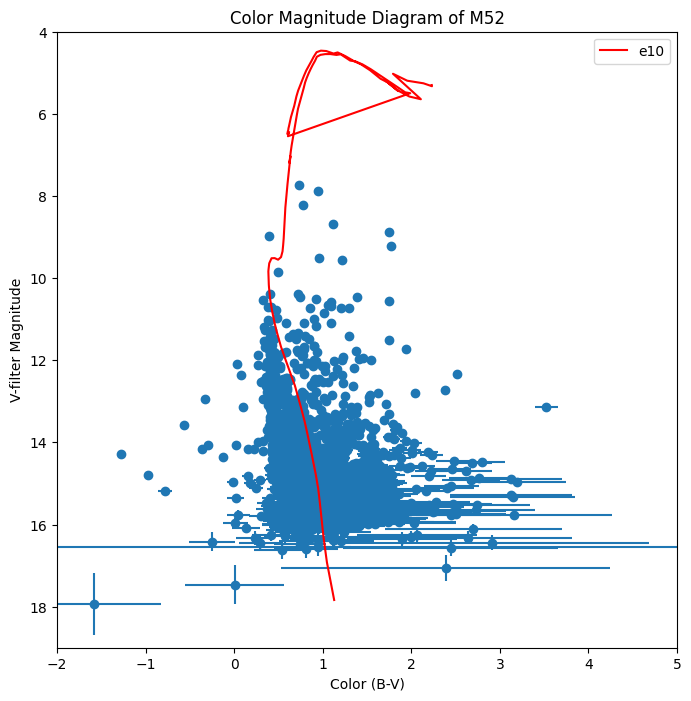

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["B-V_err"]) + 3 * np.nanstd(M52_fluxtable["B-V_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["B-V_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["B-V"], clean_data["Vmag"], xerr = clean_data["B-V_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e10["B"] - e10["V"], e10["V"]+6, c = "r", label = "e10", zorder = 2)
plt.xlabel("Color (B-V)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,4])
plt.xlim([-2,5])
plt.legend()
plt.show()

The best fitting isochrone based off the the weight least square value was the one corresponding to 3e7

## Isochrone Fitting VR

We will only do the three close ones from above, as the VR CMD is significantly worse.

Additionally, bc of the data quality errors, we will not do more chi-square testing but merely overplot the isochromes.

e7

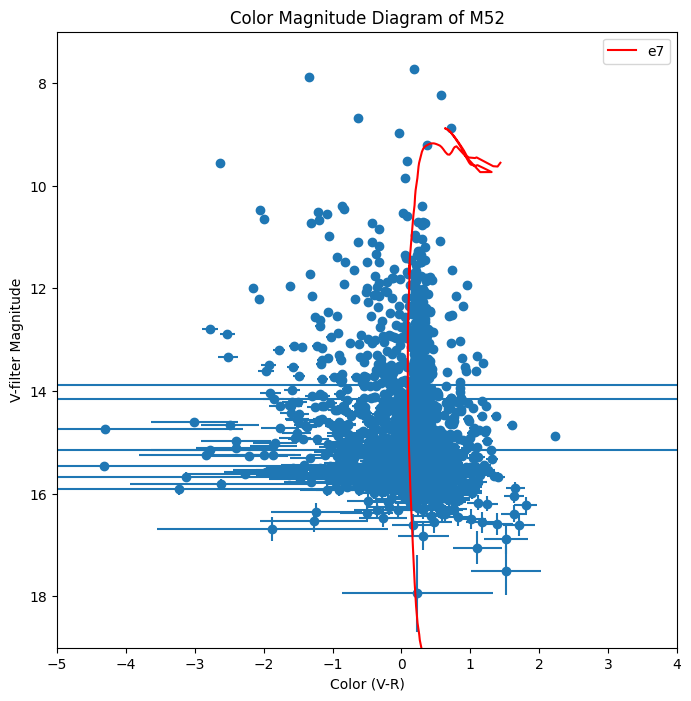

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["V-R_err"]) + 3 * np.nanstd(M52_fluxtable["V-R_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["V-R_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["V-R"], clean_data["Vmag"], xerr = clean_data["V-R_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e7["V"] - e7["R"]+ 0.25, e7["V"] + 17, c = "r", label = "e7", zorder = 2)
plt.xlabel("Color (V-R)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,7])
plt.xlim([-5,4])
plt.legend()
plt.show()

3e7

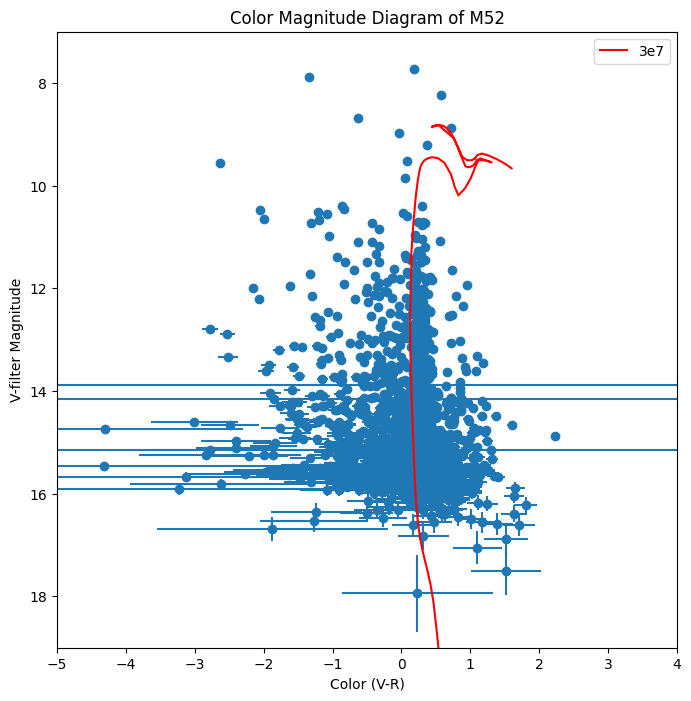

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["V-R_err"]) + 3 * np.nanstd(M52_fluxtable["V-R_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["V-R_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["V-R"], clean_data["Vmag"], xerr = clean_data["V-R_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e37["V"] - e37["R"]+ 0.25, e37["V"] + 15, c = "r", label = "3e7", zorder = 2)
plt.xlabel("Color (V-R)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,7])
plt.xlim([-5,4])
plt.legend()
plt.show()

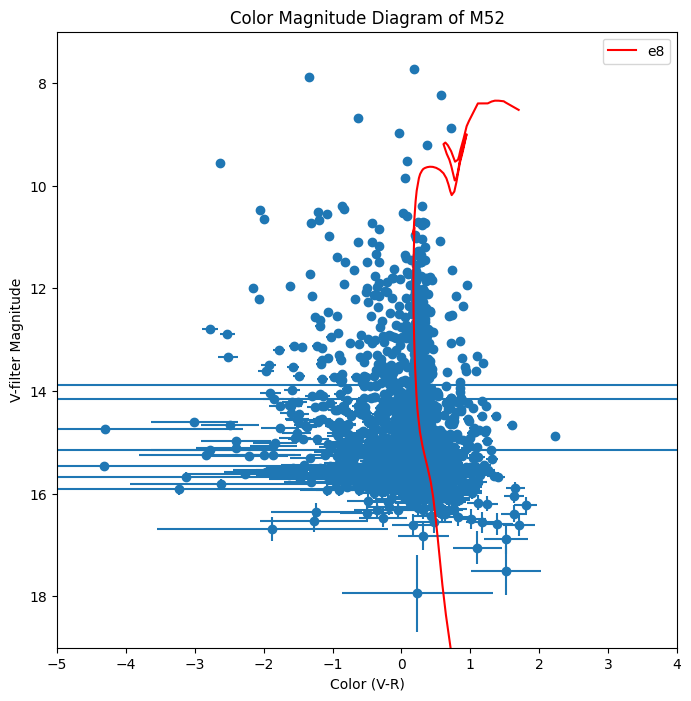

In [ ]:
# stat calc
limit_BV_err = np.nanmean(M52_fluxtable["V-R_err"]) + 3 * np.nanstd(M52_fluxtable["V-R_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# cleaned data
mask = (M52_fluxtable["V-R_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# plotting
plt.figure(figsize=(8,8))
plt.errorbar(clean_data["V-R"], clean_data["Vmag"], xerr = clean_data["V-R_err"], yerr = clean_data["Vmag_err"], fmt = 'o', zorder = 1)
plt.plot(e8["V"] - e8["R"]+ 0.25, e8["V"] + 13, c = "r", label = "e8", zorder = 2)
plt.xlabel("Color (V-R)")
plt.ylabel("V-filter Magnitude")
plt.title("Color Magnitude Diagram of M52")
plt.ylim([19,7])
plt.xlim([-5,4])
plt.legend()
plt.show()

##Matrix of Images

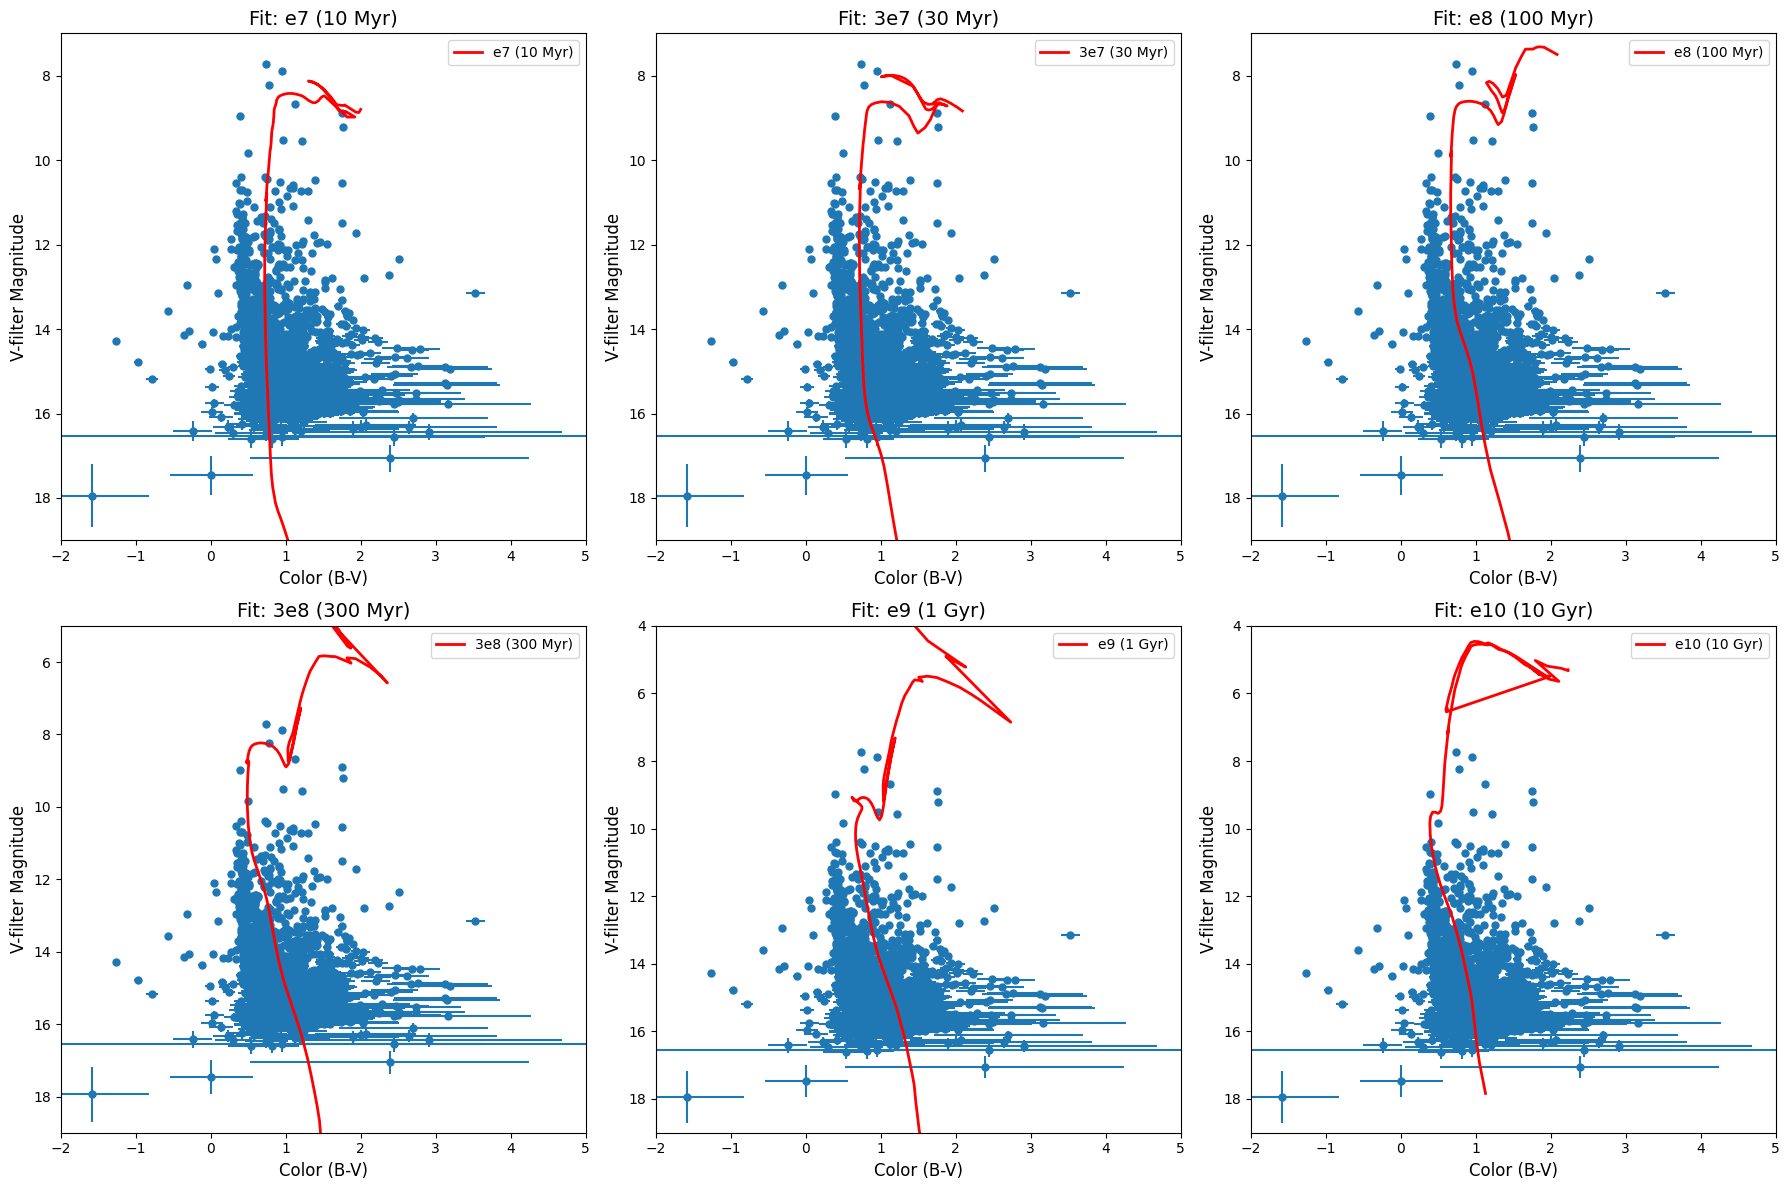

In [ ]:
# Calculate limits for th eplotting
limit_BV_err = np.nanmean(M52_fluxtable["B-V_err"]) + 3 * np.nanstd(M52_fluxtable["B-V_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# apply mask to them like above
mask = (M52_fluxtable["B-V_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# sets up the various plotting
iso_settings = [
    (e7,  "e7 (10 Myr)",   0.8348805057817346, 16.247689202571127, 7),
    (e37, "3e7 (30 Myr)",  0.800279921742284, 14.1753949248116, 7),
    (e8,  "e8 (100 Myr)",  0.7171673757676543, 11.977361299346535, 7),
    (e38, "3e8 (300 Myr)", 0.5,                9.5,                5),
    (e9,  "e9 (1 Gyr)",    0.5,                8.5,                4),
    (e10, "e10 (10 Gyr)",  0,                6,                  4)
]

# 3x2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten() # Flattens the 2x3 grid into a 1D array for easy looping

# plot
for i, ax in enumerate(axes):
    # gets the needed values for this plot
    iso_data, label, x_shift, y_shift, y_limit_bottom = iso_settings[i]
    # plot it here
    ax.errorbar(clean_data["B-V"], clean_data["Vmag"],
                xerr=clean_data["B-V_err"], yerr=clean_data["Vmag_err"],
                fmt='o', color='tab:blue', markersize=5, zorder=1)

    # isochrone stuf here
    iso_x = iso_data["B"] - iso_data["V"] + x_shift
    iso_y = iso_data["V"] + y_shift
    ax.plot(iso_x, iso_y, c="r", linewidth=2, label=label, zorder=2)

    ax.set_xlabel("Color (B-V)", fontsize=12)
    ax.set_ylabel("V-filter Magnitude", fontsize=12)
    ax.set_title(f"Fit: {label}", fontsize=14)
    ax.set_xlim([-2,5])
    ax.set_ylim([19, y_limit_bottom])
    ax.legend(loc='upper right')
    #ax.grid(True, alpha=0.3)
# layout
#plt.suptitle("Isochrone Fits for M52", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

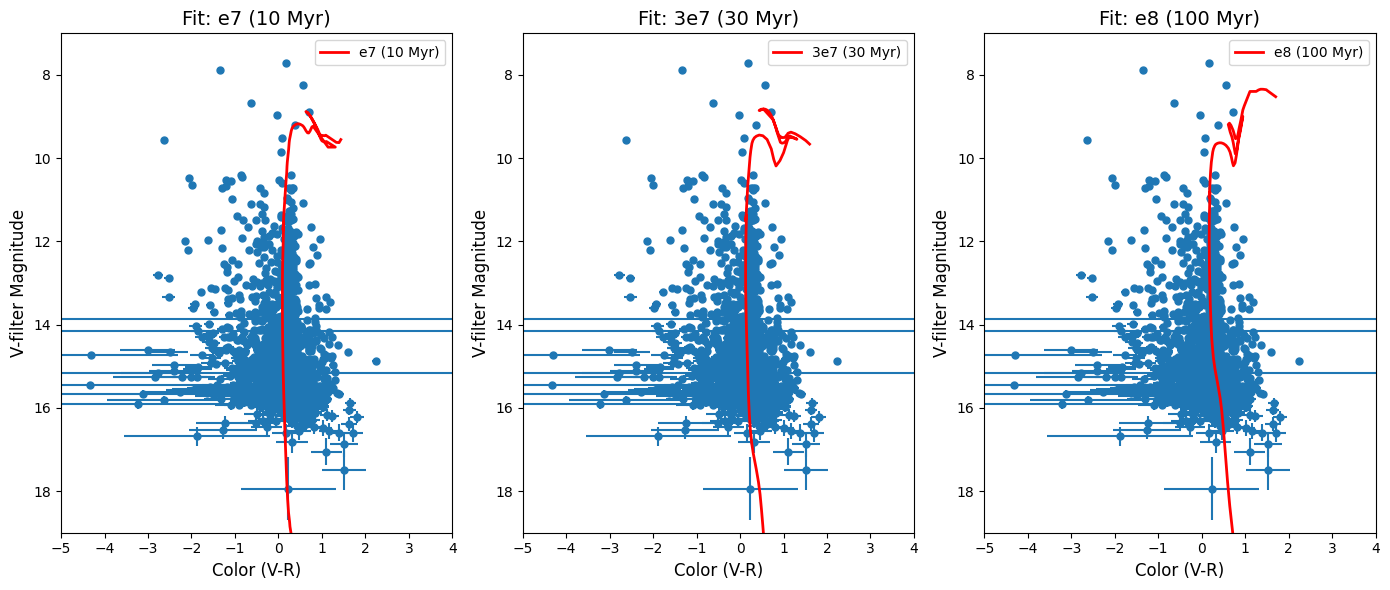

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate limits for th eplotting
limit_BV_err = np.nanmean(M52_fluxtable["V-R_err"]) + 3 * np.nanstd(M52_fluxtable["V-R_err"])
limit_V_err  = np.nanmean(M52_fluxtable["Vmag_err"]) + 3 * np.nanstd(M52_fluxtable["Vmag_err"])

# apply mask to them like above
mask = (M52_fluxtable["V-R_err"] < limit_BV_err) & (M52_fluxtable["Vmag_err"] < limit_V_err)
clean_data = M52_fluxtable[mask]

# sets up the various plotting
iso_settings = [
    (e7,  "e7 (10 Myr)",   0.25, 17, 7),
    (e37, "3e7 (30 Myr)",  0.25, 15, 7),
    (e8,  "e8 (100 Myr)",  0.25, 13, 7)
]

# 3x2
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
axes = axes.flatten() # Flattens the 2x3 grid into a 1D array for easy looping

# plot
for i, ax in enumerate(axes):
    # gets the needed values for this plot
    iso_data, label, x_shift, y_shift, y_limit_bottom = iso_settings[i]
    # plot it here
    ax.errorbar(clean_data["V-R"], clean_data["Vmag"],
                xerr=clean_data["V-R_err"], yerr=clean_data["Vmag_err"],
                fmt='o', color='tab:blue', markersize=5, zorder=1)

    # isochrone stuf here
    iso_x = iso_data["V"] - iso_data["R"] + x_shift
    iso_y = iso_data["V"] + y_shift
    ax.plot(iso_x, iso_y, c="r", linewidth=2, label=label, zorder=2)

    ax.set_xlabel("Color (V-R)", fontsize=12)
    ax.set_ylabel("V-filter Magnitude", fontsize=12)
    ax.set_title(f"Fit: {label}", fontsize=14)
    ax.set_xlim([-5,4])
    ax.set_ylim([19, y_limit_bottom])
    ax.legend(loc='upper right')
    #ax.grid(True, alpha=0.3)
# layout
#plt.suptitle("Isochrone Fits for M52", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()